In [1]:
import numpy as np
import pandas as pd
import os
import re
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import csv

# Paramétrage de l'affichage des dataframes
pd.set_option('display.max_columns', 12)
pd.set_option('display.max_rows', None)

In [2]:
# Détermination du temps de vieillissement à partir du nom de fichier
def age(parameters):
    compound_mapping = {
        '240208': 349,
        '240308': 378,
        '240405': 406,
        '240503': 434,
        '240607': 462,
        'frais': 0
    }
    
    for key, value in compound_mapping.items():
        if key in parameters:
            return value
    return 0

In [3]:
# Indiquer emplacement des données
#directory = r'/Users/prénomnom/Desktop/Fichier' (exemple)
directory = r'/Users/nicolasgros/Desktop/Études/Stages/INP - CRCC/data py-GCMS/Vieillissement rubans'

dataframes = []
tapes = []
ages = []
filenames = []

for filename in os.listdir(directory):
    if filename.endswith('.txt'):
        file_path = os.path.join(directory, filename)
        
        try:
            df = pd.read_csv(file_path, skiprows=12, delimiter='\t', names=['Ret.Time', 'Absolute Intensity', 'Relative Intensity'], 
                             dtype={'Ret.Time': float, 'Absolute Intensity': int, 'Relative Intensity': float}, 
                             index_col='Ret.Time', decimal=',', encoding='utf-8')
        except UnicodeDecodeError:
            try:
                df = pd.read_csv(file_path, skiprows=12, delimiter='\t', names=['Ret.Time', 'Absolute Intensity', 'Relative Intensity'], 
                                 dtype={'Ret.Time': float, 'Absolute Intensity': int, 'Relative Intensity': float}, 
                                 index_col='Ret.Time', decimal=',', encoding='latin1')
            except UnicodeDecodeError:
                df = pd.read_csv(file_path, skiprows=12, delimiter='\t', names=['Ret.Time', 'Absolute Intensity', 'Relative Intensity'], 
                                 dtype={'Ret.Time': float, 'Absolute Intensity': int, 'Relative Intensity': float}, 
                                 index_col='Ret.Time', decimal=',', encoding='cp1252')

        parameters = re.split(r'[-._ ]', filename)
        tapes.append(parameters[0])
        ages.append(age(parameters[-2]))
        filenames.append(filename)
        dataframes.append(df)

data = pd.concat(dataframes, axis=1)
data = data.loc[:, ~data.columns.str.contains('Relative Intensity')]
data = data.T.reset_index(drop=True).rename_axis('Index')

data['tape'] = tapes
data['age'] = ages
data['file name'] = filenames

cols = list(data.columns)
cols = ['tape'] + [col for col in cols if col != 'tape']
data = data[cols]

data.sort_values(by=['tape', 'age'], inplace=True)
data.reset_index(drop=True, inplace=True)

data

Ret.Time,tape,1.1,1.102,1.103,1.105,1.107,...,38.993,38.995,38.997,38.998,age,file name
0,raa12,38819,38878,38998,38708,39030,...,90570,92847,92677,92250,0,raa12_frais.txt
1,raa12,44385,42988,41747,40755,39804,...,95306,96311,98679,100647,349,raa12_vieux_240208.txt
2,raa12,44779,45498,45545,43416,40974,...,99452,97732,97616,98892,378,raa12_vieux_240308.txt
3,raa12,46368,44664,44969,47232,48589,...,118311,117807,115363,113335,406,raa12_vieux_240405.txt
4,raa12,39490,40534,40219,38790,38455,...,96076,95085,93358,92420,434,raa12_vieux_240503.txt
5,raa12,55825,55554,56138,56626,55586,...,108784,109630,109919,110456,462,raa12_vieux_240607.txt
6,raa13,83062,84120,85009,84116,82422,...,210910,207922,207659,209555,0,raa13_frais.txt
7,raa13,38195,36984,37014,37993,38900,...,299103,298308,300505,299331,349,raa13_vieux_240208.txt
8,raa13,85535,86962,88205,88769,89897,...,126559,125853,127113,128147,378,raa13_vieux_240308.txt
9,raa13,37194,37909,38394,39640,41416,...,250436,251169,251983,249375,406,raa13_vieux_240405.txt


In [4]:
# Les données n'étant pas rigoureusement collectées touttes les 0.001 min,
# seules les colonnes finissant en 0.000 ou 0.005 sont conservées,
# afin de permettre de décaler les chromato pour les supperposer
selected_columns = [col for col in data.columns[1:-2] if str(col).endswith(('5', '0'))]
data_selected = data.loc[:, ['tape'] + list(selected_columns) + ['age', 'file name']]

data_selected

Ret.Time,tape,1.105,1.115,1.125,1.135,1.145,...,38.965,38.975,38.985,38.995,age,file name
0,raa12,38708,39054,39467,39238,39160,...,92990,94357,93337,92847,0,raa12_frais.txt
1,raa12,40755,45904,42703,40658,41514,...,95549,96870,94791,96311,349,raa12_vieux_240208.txt
2,raa12,43416,41256,41241,42706,42186,...,100195,101500,99042,97732,378,raa12_vieux_240308.txt
3,raa12,47232,46880,47437,48634,46757,...,117911,112788,116568,117807,406,raa12_vieux_240405.txt
4,raa12,38790,39184,40838,38868,40251,...,92859,95152,97491,95085,434,raa12_vieux_240503.txt
5,raa12,56626,57740,58827,56693,55908,...,110355,108063,109172,109630,462,raa12_vieux_240607.txt
6,raa13,84116,80415,81221,81286,77474,...,206493,209813,208676,207922,0,raa13_frais.txt
7,raa13,37993,37622,37247,38034,34445,...,288547,297260,294113,298308,349,raa13_vieux_240208.txt
8,raa13,88769,95420,100772,104142,109225,...,122529,122039,125792,125853,378,raa13_vieux_240308.txt
9,raa13,39640,36793,39962,40484,40125,...,243489,243753,249190,251169,406,raa13_vieux_240405.txt


In [5]:
# Défini les décallages pour chaque chromatogramme
shift_values = {
    'raa12': {349: -0.017, 378: -0.015, 406: -0.03, 434: -0.02, 462: -0.017},
    'raa13': {349: -0.007, 378: 0.015, 406: -0.012, 434: 0, 462: -0.012},
    'raa14': {349: -0.018, 378: 0.004, 406: -0.026, 434: -0.01, 462: -0.018},
    'raa15': {349: -0.029, 378: -0.008, 406: -0.027, 434: -0.035, 462: -0.029},
    'raa16': {349: -0.025, 378: -0.013, 406: -0.018, 434: -0.030, 462: -0.027}
}

# Converti le décallage temporel en décallage de colonnes
def convert_shifts_to_columns(shift_values, step_size):
    column_shifts = {}
    for tape, age_shifts in shift_values.items():
        column_shifts[tape] = {age: int(shift / step_size) for age, shift in age_shifts.items()}
    return column_shifts
step_size = 0.002
column_shifts = convert_shifts_to_columns(shift_values, step_size)

# Décale les données dans le dataframe
def shift_columns(data, column_shifts):
    non_numeric_cols = ['tape', 'age', 'file name']
    numeric_data = data.drop(columns=non_numeric_cols)
    shifted_data = numeric_data.transpose()
    for idx, row in data.iterrows():
        tape = row['tape']
        age = row['age']
        if tape in column_shifts and age in column_shifts[tape]:
            shift = column_shifts[tape][age]
            shifted_data[idx] = shifted_data[idx].shift(periods=-shift)
    
    shifted_numeric_data = shifted_data.transpose()
    final_data = pd.concat([data[['tape']], shifted_numeric_data], axis=1)
    final_data = pd.concat([final_data, data[['age', 'file name']]], axis=1)
    return final_data

In [6]:
# Applique le décalage
data_shifted = shift_columns(data, column_shifts)

data_raa12_shifted = data_shifted[data_shifted["tape"]=="raa12"]
data_raa13_shifted = data_shifted[data_shifted["tape"]=="raa13"]
data_raa14_shifted = data_shifted[data_shifted["tape"]=="raa14"]
data_raa15_shifted = data_shifted[data_shifted["tape"]=="raa15"]
data_raa16_shifted = data_shifted[data_shifted["tape"]=="raa16"]

In [7]:
# Représente le chromatogramme, avec possibilité de réduire la plage temporelle,
# et d'afficher les pics identifiés.
def plot_TIC(data_plot_spectra, start_time=None, end_time=None, found_tr=None, y_limit=None):
    Tr = data_plot_spectra.columns[1:-3].astype(float)
    data_to_plot = data_plot_spectra.values[:, 1:-3]

    if start_time is not None:
        start_idx = np.searchsorted(Tr, start_time, side='left')
    else:
        start_idx = 0

    if end_time is not None:
        end_idx = np.searchsorted(Tr, end_time, side='right')
    else:
        end_idx = len(Tr)

    Tr_filtered = Tr[start_idx:end_idx]
    data_filtered = data_to_plot[:, start_idx:end_idx]

    plt.figure(figsize=(12, 4))
    cmap = cm.coolwarm(np.linspace(0, 0.8, len(data_filtered)))

    for row in range(len(data_filtered)):
        Int = data_filtered[row]
        color = cmap[row]
        age = data_plot_spectra.values[row, data_plot_spectra.columns.get_loc('age')]
        if age == 0:
            color = 'black'
            label = 'Age: 0'
        else:
            label = f'Age: {age}'
        plt.plot(Tr_filtered, Int, color=color, linestyle='-', linewidth=0.5, alpha=1, label=label)
    
    if found_tr is not None:
            plt.axvline(x=found_tr, color='black', linestyle='--', linewidth=1, label=f'Found TR: {found_tr}')
    
    if y_limit is not None:
        plt.ylim(None, y_limit)
    
    plt.xlabel('Temps de rétention (min)')
    plt.ylabel('Intensité')
    plt.legend()
    plt.show()
    
# Représente les chromatrogrammes avec un décalage vertical
def plot_with_vshift(data, vshift, start_time=None, end_time=None, found_tr=None, y_limit=None):
    data2 = data.copy()
    numeric_columns = data.columns[1:-3]
    i = 1
    for idx, row in data.iterrows():
        data2.loc[idx, numeric_columns] = row[numeric_columns].astype(float) + i*vshift
        i += 1
    return data2

## Data processing

In [9]:
# Définition des fonctions utilisées pour le calcul des intensités
# Ajustement des paramètres de recherche des pics manuellement
def closest_inferior_value(value, value_list):
    closest = None
    for v in value_list:
        if v < value:
            if closest is None or value - v < value - closest:
                closest = v
    return closest

# Ajuste le temps de rétention
def find_max_intensity(df, row, retention_time, window=0.1):
    if df.loc[row, 'tape'] == 'raa12':
        if retention_time > 12:
            if retention_time < 13:
                window = 0.2
    if df.loc[row, 'tape'] == 'raa13':
        if retention_time > 4.3:
            if retention_time < 5:
                window = 0.2
        if retention_time > 19:
            if retention_time < 19.5:
                window = 0.2
    if df.loc[row, 'tape'] == 'raa14':
        if retention_time > 10.9:
            if retention_time < 11.1:
                window = 0.2
        if retention_time > 11.5:
            if retention_time < 11.92:
                window = 0.2
    if df.loc[row, 'tape'] == 'raa15':
        if retention_time < 9:
            window = 0.2
        if retention_time > 19.5:
            if retention_time < 19.8:
                window = 0.2
        if retention_time > 31.5:
            if retention_time < 32.5:
                window = 0.1
    if df.loc[row, 'tape'] == 'raa16':
        if retention_time > 1.7:
            if retention_time < 3:
                window = 0.13
        if retention_time > 3.5:
            if retention_time < 3.7:
                window = 0.15
        if retention_time > 3.8:
            if retention_time < 3.9:
                window = 0.15
        if retention_time > 6:
            if retention_time < 9:
                window = 0.15
                
    retention_times = df.columns[10:-100].astype(float)
    start_time = closest_inferior_value(retention_time - window, retention_times)
    end_time = closest_inferior_value(retention_time + window, retention_times)
    max_intensity = df.loc[row, start_time:end_time].max()
    max_retention_time = df.loc[row, start_time:end_time].idxmax()

    return max_intensity, max_retention_time


def relative_intensity(df, row, retention_time_1, retention_time_2):    
    I_peak = find_max_intensity(df, row, retention_time_1)[0]
    ref_peak = find_max_intensity(df, row, retention_time_2)[0]
    return I_peak / ref_peak

In [10]:
# Recherche tous les pics au dessus d'une valeur seuil
def find_peak_rt(df, row, start, end, threshold):
    Tr = df.columns[1:-3].astype(float)
    intensity_values = df.iloc[row, 1:-3].values
    derivate = np.gradient(intensity_values)
    
    # Filter the retention times and intensities based on start and end
    start_idx = np.searchsorted(Tr, start, side='left')
    end_idx = np.searchsorted(Tr, end, side='right')
    Tr_filtered = Tr[start_idx:end_idx]
    intensity_filtered = intensity_values[start_idx:end_idx]
    derivate_filtered = derivate[start_idx:end_idx]

    # Step 1: Find peaks using find_peaks
    peaks, _ = find_peaks(intensity_filtered, height=threshold)
    
    # Step 2: Find the retention time where the derivative crosses 0 closest to the found peaks
    zero_crossings = np.where(np.diff(np.sign(derivate_filtered)))[0]
    peak_rts = []
    peak_rts2 = []
    
    for peak_idx in peaks:
        peak_ret_time = Tr_filtered[peak_idx]
        closest_zero_crossing_idx = np.argmin(np.abs(Tr_filtered[zero_crossings] - peak_ret_time))
        closest_zero_crossing = zero_crossings[closest_zero_crossing_idx]
        peak_rts.append(Tr_filtered[closest_zero_crossing])
        peak_rts2.append(Tr_filtered[peak_idx])
    
    return peak_rts

In [11]:
# Détermine l'étalement du pic
# Ajustement manuel
def find_peak_range(df, row, start, end, peak):
    if df.loc[row, 'tape'] == 'raa12':
        if peak > 7:
            if peak < 7.2:
                return 7.025, 7.17
        if peak > 7.2:
            if peak < 7.4:
                return 7.28, 7.43
    if df.loc[row, 'tape'] == 'raa13':
        if peak > 1:
            if peak < 2.5:
                return 1.75, 2.30
        if peak > 26.5:
            if peak < 26.8:
                return 26.7, 26.81
        if df.loc[row, 'age'] == 462:
            if peak > 4.5:
                if peak < 5:
                    return 4.8, 4.9
            if peak > 26.8:
                if peak < 26.9:
                    return 26.82, 26.93
        if df.loc[row, 'age'] == 349:
            if peak > 18.25:
                if peak < 18.5:
                    return 18.26, 18.32
    if df.loc[row, 'tape'] == 'raa14':
        if df.loc[row, 'age'] == 434:
            if peak > 2.27:
                if peak < 2.5:
                    return 2.29, 2.38
        if peak > 26.5:
            if peak < 26.8:
                return 26.7, 26.81
        if df.loc[row, 'age'] == 462:
            if peak > 2.27:
                if peak < 2.5:
                    return 2.29, 2.38
    if df.loc[row, 'tape'] == 'raa15':
        if peak > 13.45:
            if peak < 14.15:
                return 13.45, 14.15
        if df.loc[row, 'age'] == 378:
            if peak > 31.5:
                if peak < 31.9:
                    return 31.78, 31.9
    if df.loc[row, 'tape'] == 'raa16':
        if peak > 4:
            if peak < 5:
                return 4, 4.2

    Tr = df.columns[1:-3].astype(float)
    intensity_values = df.iloc[row, 1:-3].values
    derivate = np.gradient(intensity_values)
    
    new_peak = find_max_intensity(df, row, peak, window=0.02)[1]
    peak = new_peak
                                                              
    start_idx = np.searchsorted(Tr, start, side='left')
    end_idx = np.searchsorted(Tr, end, side='right')
    Tr_filtered = Tr[start_idx:end_idx]
    intensity_filtered = intensity_values[start_idx:end_idx]
    derivate_filtered = derivate[start_idx:end_idx]
    
    peak_index = np.searchsorted(Tr_filtered, peak)
    start = None
    i = 2
    while start == None:
        if derivate_filtered[peak_index-i] <= 0:
            start = peak_index-i
        i += 1
    end = None
    i = 2
    while end == None:
        if derivate_filtered[peak_index+i] >= 0:
            end = peak_index+i
        i += 1
    start_tr = Tr_filtered[start]
    end_tr = Tr_filtered[end]

    return start_tr, end_tr

[[12.148, 12.095, 12.173], [13.35, 13.327, 13.385], [13.557, 13.525, 13.615], [13.858, 13.823, 13.887], [13.92, 13.885, 14.002], [14.148, 14.118, 14.205]]


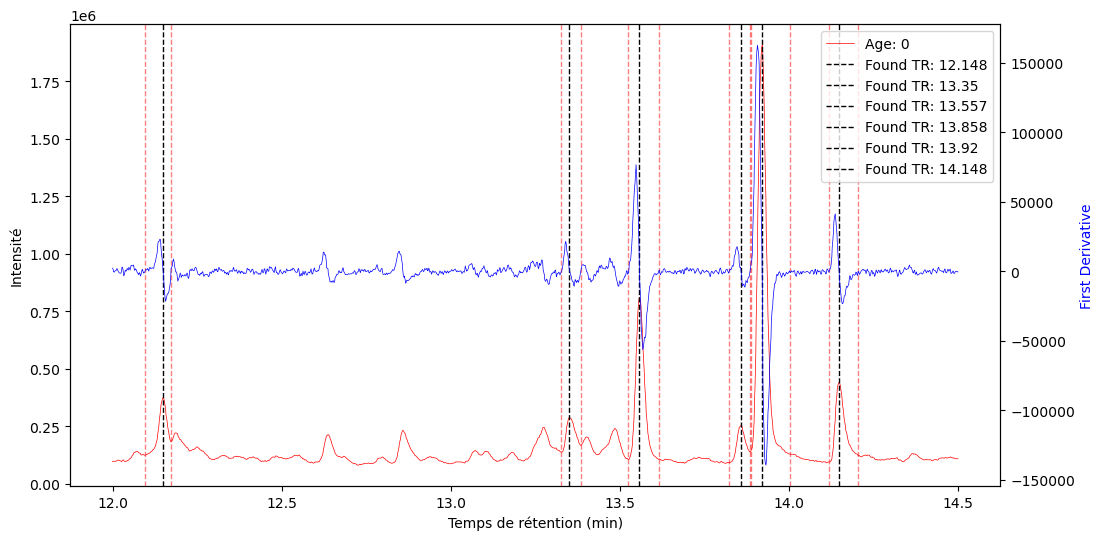

In [12]:
# Illustration de comment sont trouvés les maximums et bases des pics
def plot_TIC_with_derivate(data_plot_spectra, row=None, start_time=None, end_time=None, peaks_info=None):
    # Extract retention times and intensities
    Tr = data_plot_spectra.columns[1:-3].astype(float)
    if row is not None:
        intensity_values = data_plot_spectra.iloc[row, 1:-3].values
        data_to_plot = np.array([intensity_values])
        derivate = np.gradient(intensity_values)
    else:
        data_to_plot = data_plot_spectra.values[:, 1:-3]

    # Filter columns based on the specified start and end retention times
    if start_time is not None:
        start_idx = np.searchsorted(Tr, start_time, side='left')
    else:
        start_idx = 0

    if end_time is not None:
        end_idx = np.searchsorted(Tr, end_time, side='right')
    else:
        end_idx = len(Tr)

    Tr_filtered = Tr[start_idx:end_idx]
    data_filtered = data_to_plot[:, start_idx:end_idx]
    derivate_filtered = derivate[start_idx:end_idx]
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    cmap = cm.viridis(np.linspace(0, 0.8, len(data_filtered)))

    for row in range(len(data_filtered)):
        Int = data_filtered[row]
        color = cmap[row]
        age = data_plot_spectra.values[row, data_plot_spectra.columns.get_loc('age')]
        if age == 0:
            color = 'red'
            label = 'Age: 0'
        else:
            label = f'Age: {age}'
        ax1.plot(Tr_filtered, Int, color=color, linestyle='-', linewidth=0.5, alpha=1, label=label)
    
    if peaks_info is not None:
        for peak_info in peaks_info:
            peak_rt, start_rt, end_rt = peak_info

            ax1.axvline(x=peak_rt, color='black', linestyle='--', linewidth=1, label=f'Found TR: {peak_rt}')
            ax1.axvline(x=start_rt, color='red', linestyle='--', linewidth=1, alpha=0.5)
            ax1.axvline(x=end_rt, color='red', linestyle='--', linewidth=1, alpha=0.5)

    ax1.set_xlabel('Temps de rétention (min)')
    ax1.set_ylabel('Intensité')
    ax1.legend()
    
    ax2 = ax1.twinx()

    ax2.plot(Tr_filtered, derivate_filtered, color='blue', linestyle='-', linewidth=0.5, alpha=1)
    ax2.set_ylabel('First Derivative', color='blue')
    
    plt.show()

peaks_info = []
peak_rts = find_peak_rt(data_shifted, 0, 12, 14.5, 250000)
for peak in peak_rts:
    peak_info = []
    peak_info.append(peak)
    peak_info.append(find_peak_range(data_shifted, 0, 12, 14.5, peak)[0])
    peak_info.append(find_peak_range(data_shifted, 0, 12, 14.5, peak)[1])
    peaks_info.append(peak_info)

print(peaks_info)

plot_TIC_with_derivate(data_shifted[:], row=0, start_time=12, end_time=14.5, peaks_info=peaks_info)

In [13]:
# Calcul de l'air d'un pic
def peak_area(df, row, start, end):
    Tr = df.columns[1:-3].astype(float)
    intensity_values_a = df.iloc[row, 1:-3].values
    
    start_idx = np.searchsorted(Tr, start, side='left')
    end_idx = np.searchsorted(Tr, end, side='right')
    Tr_filtered_a = Tr[start_idx:end_idx]
    intensity_filtered_a = intensity_values_a[start_idx:end_idx]
    
    baseline_start = intensity_filtered_a[0]
    baseline_end = intensity_filtered_a[-1]
    baseline_min = min(baseline_start, baseline_end)
    baseline = np.linspace(baseline_min, baseline_min, len(Tr_filtered_a))
    
    area = np.trapz(intensity_filtered_a, Tr_filtered_a)*60
    
    return area, Tr_filtered_a, intensity_filtered_a, baseline

[[10.297, 14.498, 12.007], [10.383, 14.498, 12.007], [10.907, 14.498, 12.007], [11.073, 14.498, 12.007], [11.137, 14.498, 12.007], [11.202, 14.498, 12.007]]


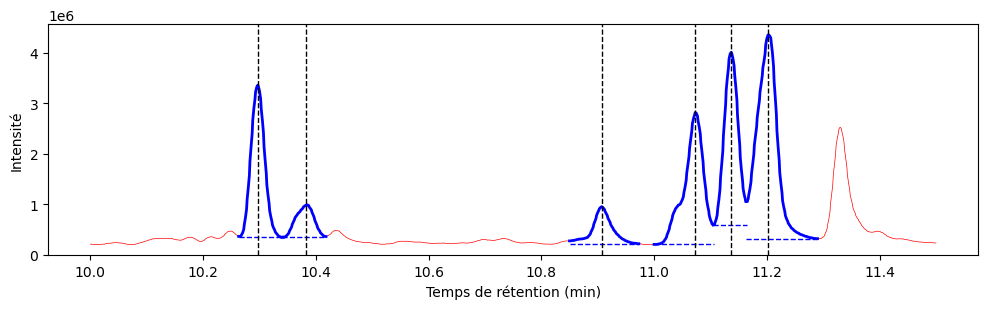

In [14]:
# Représentation du chromatogramme avec illustration de l'aire des pics
def plot_TIC_with_area(data_plot_spectra, peak_rts, row=None, start_time=None, end_time=None, peaks_info=None, int_lim=280000):
    peaks_info = []
        
    for peak in peak_rts:
        if peak > start_time:
            if peak < end_time:
                peak_info = []
                peak_info.append(peak)
                peak_info.append(find_peak_range(data_plot_spectra, row, start_time, end_time, peak)[0])
                peak_info.append(find_peak_range(data_plot_spectra, row, start_time, end_time, peak)[1])
                peaks_info.append(peak_info)
    
    Tr = data_plot_spectra.columns[1:-3].astype(float)
    if row is not None:
        intensity_values = data_plot_spectra.iloc[row, 1:-3].values
        data_to_plot = np.array([intensity_values])
    else:
        data_to_plot = data_plot_spectra.values[:, 1:-3]

    if start_time is not None:
        start_idx = np.searchsorted(Tr, start_time, side='left')
    else:
        start_idx = 0

    if end_time is not None:
        end_idx = np.searchsorted(Tr, end_time, side='right')
    else:
        end_idx = len(Tr)

    Tr_filtered = Tr[start_idx:end_idx]
    data_filtered = data_to_plot[:, start_idx:end_idx]
    
    fig, ax1 = plt.subplots(figsize=(12, 3))
    
    Int_filtered = data_filtered[0]
    color = 'red'
    age == data_plot_spectra.values[row, -2]
    label = f'Age: {age}'
    ax1.plot(Tr_filtered, Int_filtered, color=color, linestyle='-', linewidth=0.5, alpha=1, label=label)

    if peaks_info is not None:
        for peak_info in peaks_info:
            peak_rt, peak_start, peak_end = peak_info

            area, Tr_peak, Int_peak, baseline = peak_area(data_plot_spectra, row, peak_start, peak_end)
            
            ax1.plot(Tr_peak, Int_peak, color='blue', linestyle='-', linewidth=2)
            ax1.plot(Tr_peak, baseline, color='blue', linestyle='--', linewidth=1)
            
            ax1.axvline(x=peak_rt, color='black', linestyle='--', linewidth=1, label=f'{peak_rt}/{round(area)}')
           
    ax1.set_xlabel('Temps de rétention (min)')
    ax1.set_ylabel('Intensité')
    
    plt.show()

# Figure 11
peaks_info = []
peak_rts = find_peak_rt(data_shifted, 6, 10, 11.25, 500000)
for peak in peak_rts:
    peak_info = []
    peak_info.append(peak)
    peak_info.append(find_peak_range(data_shifted, 0, 12, 14.5, peak)[0])
    peak_info.append(find_peak_range(data_shifted, 0, 12, 14.5, peak)[1])
    peaks_info.append(peak_info)

print(peaks_info)

plot_TIC_with_area(data_shifted, peak_rts, row=6, start_time=10, end_time=11.5, peaks_info=peaks_info)

## Ajout manuel des données

In [16]:
# Ajout des écarts types déterminés sur les triplicats
data_std_dev = {
    4.195: 0.422090,
    7.09: 0.249102,
    7.34: 0.233311,
    7.95: 0.261898,
    8.14: 0.079149,
    9.47: 0.091986,
    9.52: 0.063641,
    10.71: 0.316373,
    11.06: 0.594536,
    11.39: 0.086344,
    13.56: 0.122192,
    13.92: 0.132870,
    14.15: 0.119034,
    15.62: 0.164431,
    15.85: 0.043214,
    16.27: 0.136542,
    16.69: 0.055270,
    16.75: 0.099366,
    16.79: 0.042288,
    16.92: 0.119484,
    17: 0.007681,
    17.98: 0.094255,
    18.06: 0.123154,
    18.13: 0.053508,
    18.2: 0.187042,
    19.28: 0.089131,
    19.47: 0.051699,
    21.78: 0.062824,
    22.87: 0.191419,
    26.89: 0.091079,
    27.22: 0.117539,
    27.42: 0.199310,
    28.02: 0.200926
}
std_devs_raa12 = pd.Series(data_std_dev, name='Standard Deviation')

data_std_dev = {
    'Support': 0.324338,
    'Support ou masse adhésive': 0.159742,
    'Masse adhésive': 0.240939,
    'Additif': 0.198470,
    'Alcène': 0.433540,
    'Alcane': 0.259073,
    'Mélange': 0.152719,
    'Indéterminé': 0.113940
}
std_devs_by_type_raa12 = pd.Series(data_std_dev, name='Standard Deviation')

In [17]:
data_std_dev = {
    2.15: 0.417830,
    2.9: 0.094924,
    3.02: 0.040863,
    3.26: 0.025010,
    3.37: 0.032061,
    3.66: 0.192956,
    3.73: 0.098139,
    3.86: 0.153198,
    4.06: 0.095299,
    4.42: 0.146187,
    4.83: 0.027205,
    6.85: 0.038295,
    7.41: 0.004929,
    7.93: 0.032077,
    10.3: 0.067055,
    10.38: 0.004550,
    10.91: 0.043161,
    11.08: 0.022777,
    11.13: 0.066450,
    11.2: 0.094182,
    11.33: 0.039067,
    11.85: 0.022569,
    12.18: 0.010325,
    12.51: 0.040185,
    13.61: 0.012498,
    13.98: 0.034333,
    14.42: 0.038578,
    14.59: 0.017559,
    14.65: 0.033187,
    14.7: 0.057667,
    14.79: 0.018616,
    14.87: 0.024272,
    14.93: 0.009951,
    15.39: 0.014555,
    15.52: 0.148259,
    15.67: 0.061078,
    15.85: 0.032769,
    15.92: 0.002085,
    16.15: 0.004211,
    16.51: 0.066059,
    18.22: 0.007566,
    18.29: 0.094568,
    18.83: 0.169886,
    19.35: 0.323799,
    20.09: 0.007063,
    26.4: 0.028847,
    26.76: 0.016506,
    26.87: 0.016728,
    27.21: 0.011754
}
std_devs_raa13 = pd.Series(data_std_dev, name='Standard Deviation')

data_std_dev = {
    'Support': 0.428285,
    'Masse adhésive': 0.033365,
    'Additif': 0.343163,
    'Alcool': 0.124631,
    'Alcène': 0.484305,
    'Ester': 0.272684,
    'Aromatique': 0.003715,
    'Terpène': 0.018597,
    'Indéterminé': 0.146692
}
std_devs_by_type_raa13 = pd.Series(data_std_dev, name='Standard Deviation')

In [18]:
data_std_dev = {
    1.87: 0.114459,
    2.2: 0.046161,
    2.24: 0.030293,
    2.33: 0.082154,
    6.46: 0.932826,
    7.89: 0.067865,
    7.95: 0.150339,
    8.42: 0.028887,
    9.52: 0.103063,
    10.25: 0.088993,
    10.39: 0.079517,
    10.71: 0.064179,
    11.04: 0.610732,
    11.38: 0.116239,
    11.86: 0.146572,
    11.97: 0.044246,
    12.71: 0.023379,
    13.12: 0.099302,
    15.46: 0.207033,
    15.58: 0.092336,
    15.7: 0.184320,
    16.08: 0.052261,
    16.44: 0.126956
}
std_devs_raa14 = pd.Series(data_std_dev, name='Standard Deviation')

data_std_dev = {
    'Support': 0.551629,
    'Masse adhésive': 0.536885,
    'Alcène': 0.064925,
    'Aromatique': 0.094909
}
std_devs_by_type_raa14 = pd.Series(data_std_dev, name='Standard Deviation')

In [19]:
data_std_dev = {
    1.98: 0.045797,
    2.43: 0.333210,
    3.03: 0.080785,
    8.12: 1.052440,
    10.07: 0.097133,
    13.05: 0.486197,
    13.9: 3.045293,
    16.79: 0.238442,
    16.87: 0.031977,
    17.08: 0.194650,
    17.27: 0.110853,
    19.05: 0.472083,
    19.66: 2.152687,
    20.1: 0.797579,
    20.61: 0.810764,
    21.03: 0.134523,
    22.55: 0.088307,
    22.75: 0.105322,
    22.8: 0.159355,
    25.35: 0.593028,
    26.81: 0.121849,
    26.88: 1.066831,
    27.54: 0.137419,
    28.07: 0.070579,
    29.1: 0.915413,
    32.99: 0.308086,
    34.03: 0.418999
}
std_devs_raa15 = pd.Series(data_std_dev, name='Standard Deviation')

data_std_dev = {
    'Support': 1.595296,
    'Masse adhésive': 0.933647,
    'Dérivé benzoïque': 1.437705,
    'Dérivé benzoïque chloré': 0.871064,
    'Diester': 0.651220,
    'Aldéhyde': 0.037393,
    'Mélange': 0.357598,
    'Indéterminé': 0.413613
}
std_devs_by_type_raa15 = pd.Series(data_std_dev, name='Standard Deviation')

In [20]:
data_std_dev = {
    2.9: 0.203097,
    3.03: 0.057734,
    3.38: 0.095868,
    3.66: 0.472872,
    3.75: 0.164634,
    3.88: 0.259964,
    4.06: 0.114014,
    4.12: 0.016406,
    6.44: 1.896176,
    7.89: 0.234207,
    7.94: 0.108585,
    8.42: 0.067164,
    10.25: 0.087062,
    10.3: 0.262941,
    10.92: 0.111571,
    11.08: 0.261632,
    11.14: 0.341393,
    11.21: 0.383230,
    11.34: 0.195024,
    11.88: 0.073823,
    11.96: 0.088044,
    12.19: 0.032082,
    12.71: 0.051792,
    13.11: 0.120487,
    13.99: 0.138732,
    14.66: 0.099187,
    14.71: 0.171160,
    14.8: 0.087902,
    14.88: 0.040123,
    14.95: 0.044674,
    15.46: 0.361000,
    15.58: 0.089984,
    15.7: 0.259552,
    16.08: 0.058156,
    16.44: 0.142471
}
std_devs_raa16 = pd.Series(data_std_dev, name='Standard Deviation')

data_std_dev = {
    'Support': 2.369689,
    'Masse adhésive': 0.047140,
    'Alcène': 0.684567,
    'Alcool': 1.076547,
    'Ester': 0.404332,
    'Aromatique': 0.088659,
    'Mélange': 0.464715,
    'Indéterminé': 0.065634
}
std_devs_by_type_raa16 = pd.Series(data_std_dev, name='Standard Deviation')

In [21]:
# Définition des temps de rétention approximatifs, des noms de composés et de leur catégorie

# RAA12
retention_times_raa12 = [4.195, 7.09, 7.34, 7.95, 8.14, 9.47, 9.52, 10.71, 11.06, 11.39,
                         
                         13.56, 13.92, 14.15, 15.62, 15.85, 16.27, 16.69, 16.75, 16.79, 16.92, 
                         
                         17, 17.98, 18.06, 18.13, 18.2, 19.28, 19.47, 21.78, 22.87, 26.89, 
                         
                         27.22, 27.42, 28.02]

compounds_raa12 = ['toluène', 'éthylbenzène', 'm-xylène', 'styrène', 'C9H14', 'C10H16', '5-éthényl-1,5-diméthylcyclohexène', 
                   '2,5-diméthyl-3-méthylidènehepta-1,5-diène', 'D-limonène', '1H-indène', 
                   
                   '1-méthyl-1H-indène', 'naphtalène', 'isothiocyanatobenzène', '2-méthylnaphtalène', '1-méthylnaphtalène', 
                   '2-tert-butyl-6-méthylphénol', '?', 'C14H28', '1,2-dihydroacénaphthylène', '?',
                   
                   '?', '?', '?', '?', '?', '?', '9H-fluorène', 'anthracène', 'C15H24', '?', 
                   
                   '?', '2,2\'-méthylènebis(6-tert-butyl-4-méthylphénol) ', '?']

compound_types_raa12 = ['Support ou masse adhésive', 'Support', 'Support ou masse adhésive', 'Support', 'Alcène', 'Alcène', 'Masse adhésive', 
                        'Masse adhésive', 'Masse adhésive', 'Support', 
                        
                        'Support', 'Support', 'Additif', 'Support', 'Support', 'Additif', 'Alcène', 'Alcène', 'Support', 
                        'Alcène', 
                        
                        'Alcène', 'Alcène', 'Alcène', 'Indéterminé', 'Mélange', 'Alcène', 'Support', 'Support', 'Alcène', 'Indéterminé', 
                        
                        'Alcane', 'Additif', 'Alcane']

compound_types_plot_raa12 = ['Support', 'Support ou masse adhésive', 'Masse adhésive', 'Additif', 'Alcène', 'Alcane', 'Mélange', 'Indéterminé']


# RAA13
retention_times_raa13 = [2.15, 2.9, 3.02, 3.26, 3.37, 3.66, 3.73, 3.86, 4.06, 4.42,
                         
                        4.83, 6.85, 7.41, 7.93, 10.3, 10.38, 10.91, 11.08, 11.13, 11.2,
                         
                        11.33, 11.85, 12.18, 12.51, 13.61, 13.98, 14.42, 14.59, 14.65, 14.7,
                         
                        14.79, 14.87, 14.93, 15.39, 15.52, 15.67, 15.85, 15.92, 16.15, 16.51,
                         
                        18.22, 18.29, 18.83, 19.35, 20.09, 26.4, 26.76, 26.87, 27.21]

compounds_raa13 = ['acide acétique', '3,5-diméthylhex-1-ène', 'méthacrylate de méthyle', 'anhydride acétique', '4-méthylheptan-1-ol',
                  '?', '?', '?', '5-méthylhept-1-ène', 'acétate de 2-hydroxyéthyle',
                  
                  'oct-1-ène', '?', 'acétate de 2-oxopropyle', 'styrène', '6-méthylheptan-1-ol', 'acétate de furfuryle ?',
                  '3-éthyl-4-méthyl-1-pentanol', '?', '3-méthylheptan-1-ol', '4-méthylheptan-1-ol',
                  
                  '5-méthylheptan-1-ol', 'octan-1-ol', '?', '?', 'benzoate d\'éthyle', 'prop-2-énoate d\'octyle', '?', '?', '?',
                  'Ethylene, diacrylate',
                  
                  'diacrylate d\'éthylène', '?', '?', '?', '?', 'acétate de (5-formylfuran-2-yl)méthyle', 'anhydride phtalique', '?', '?', '?',
                   
                  '?', '2,6-di-tert-butylphénol', '?', 'phtalate de diéthyle (DEP)', '?', '?', '?', '?', '?']

compound_types_raa13 = ['Support', 'Alcène', 'Masse adhésive', 'Support', 'Alcool', 'Alcène', 'Alcène', 'Alcène', 'Alcène', 'Support',
                      
                      
                      'Alcène', 'Support', 'Alcène', 'Support', 'Ester', 'Aromatique', 'Alcool', 'Terpène', 'Alcool',
                      'Alcool',
                      
                      'Alcool', 'Alcool', 'Alcool', 'Alcool', 'Ester', 'Ester', 'Ester', 'Ester', 'Ester', 'Ester',
                      
                      'Ester', 'Ester', 'Alcool', 'Ester', 'Indéterminé', 'Ester', 'Additif', 'Support', 'Support', 'Support',
                      
                      'Support', 'Additif', 'Ester', 'Additif', 'Support', 'Indéterminé', 'Indéterminé', 'Indéterminé', 'Indéterminé']

compound_types_plot_raa13 = ['Support', 'Masse adhésive', 'Additif', 'Alcool', 'Alcène' ,'Ester', 'Aromatique', 
                             'Terpène', 'Indéterminé']

# RAA14
retention_times_raa14 = [1.87, 2.2, 2.24, 2.33, 6.46, 7.89, 7.95, 8.42, 9.52, 
                         
                         10.25, 10.39, 10.71, 11.04, 11.38, 11.86, 11.97, 12.71, 13.12, 15.46,
                         
                         15.58, 15.7, 16.08, 16.44]

compounds_raa14 = ['2-méthylpent-1-ène', '?', '?', '?', '2,4-diméthylhept-1-ène', '2,4,6-triméthylhept-1-ène', 'styrène',
                   '2,4,6-triméthylhepta-1,6-diène', '5-éthényl-1,5-diméthylcyclohexène',
                   
                   '4,6-diméthylnon-2-ène', '?', '2,5-diméthyl-3-méthylidènehepta-1,5-diène', 'D-limonène', '?',
                   '2,4,6-triméthylnon-1-ène (méso)', '2,4,6-triméthylnon-1-ène (racémique)', '2,4,6,8-tétraméthylnon-1-ène',
                   '2,4,6,8-tétraméthylnona-1,8-diène', '2,4,6,8-tétraméthylundéc-1-ène (isotactique)',
                   
                   '2,4,6,8-tétraméthylundéc-1-ène (hétérotactique)', '2,4,6,8-tétraméthylundéc-1-ène (syndiotactique)', '2,4,6,8,10-pentaméthylundéc-1-ène (isotactique)', 
                   '2,4,6,8,10-pentaméthylundécadi-1,10-ène (isotactique)']

compound_types_raa14 = ['Support', 'Support', 'Support', 'Support', 'Support', 'Support', 'Masse adhésive', 'Support', 'Masse adhésive',
                        
                        'Support', 'Alcène', 'Masse adhésive', 'Masse adhésive', 'Aromatique', 'Support', 'Support', 'Support', 'Support', 'Support',
                        
                        'Support', 'Support', 'Support', 'Support']

compound_types_plot_raa14 = ['Support', 'Masse adhésive', 'Alcène', 'Aromatique']


# RAA15
retention_times_raa15 = [1.98, 2.43, 3.03, 8.12, 10.07, 13.05, 13.9, 16.79, 16.87, 17.08, 
                         
                         17.27, 19.05, 19.66, 20.1, 20.61, 21.03, 22.55, 22.75, 22.8, 25.35, 
                         
                         26.81, 26.88, 27.54, 28.07, 29.1, 32.99]

compounds_raa15 = ['butanal', 'butan-1-ol / benzène', 'méthacrylate de méthyle ', 'acrylate de butyle', 
                   'méthacrylate de butyle', 'benzoate de vinyle', 'acide benzoïque',
                   'biphényle', 'acide 4-vinylbenzoïque', 'benzoate de 2-chloroéthyle', 
                   
                   'benzoate de 2-hydroxyéthyle', 'téréphtalate de divinyle', 'acide 4-(vinyloxycarbonyl)benzoïque', '?', '?', '?', '?', '?', '?', 
                   'dibenzoate d\'éthylène',
                   
                   '?', 'téréphtalate de di-2-chloroéthyle', '?', '?', 'téréphtalate de 2-(benzoyloxy)éthyle et de vinyle', '?']

compound_types_raa15 = ['Aldéhyde', 'Mélange', 'Masse adhésive', 'Masse adhésive', 'Masse adhésive', 'Support', 'Support', 'Support', 'Support', 'Support', 
                        
                        'Support', 'Support', 'Support', 'Diester', 'Indéterminé', 'Mélange', 'Dérivé benzoïque', 'Indéterminé', 'Indéterminé', 'Dérivé benzoïque', 
                        
                        'Mélange', 'Dérivé benzoïque chloré', 'Indéterminé', 'Indéterminé', 'Dérivé benzoïque', 'Indéterminé']

compound_types_plot_raa15 = ['Support', 'Masse adhésive', 'Dérivé benzoïque', 'Dérivé benzoïque chloré', 'Diester', 'Aldéhyde', 'Mélange', 'Indéterminé']


# RAA16
retention_times_raa16 = [2.9, 3.03, 3.38, 3.66, 3.75, 3.88, 4.06, 4.12, 6.44, 7.89, 
                         
                         7.94, 8.42, 10.25, 10.3, 10.92, 11.08, 11.14, 11.21, 11.34, 11.88, 
                         
                         11.96, 12.19, 12.71, 13.11, 13.99, 14.66, 14.71, 14.8, 14.88, 14.95, 
                         
                         15.46, 15.58, 15.7, 16.08, 16.44]

compounds_raa16 = ['3,5-diméthylhex-1-ène', 'méthacrylate de méthyle', '?', '?', 'C8H16', 'C8H16', 'C8H16', '?',
                   '2,4-diméthylhept-1-ène', '2,4,6-triméthylhept-1-ène', 
                   
                   'styrène', '2,4,6-triméthylhepta-1,6-diène', '4,6-diméthylnon-2-ène',
                   '6-méthylheptan-1-ol', '3-éthyl-4-méthylpentan-1-ol', '?', 'octan-1-ol', '4-méthylheptan-1-ol',
                   '5-méthylheptan-1-ol', '2,4,6-triméthylnon-1-ène (méso)', 
                   
                   '2,4,6-triméthylnon-1-ène (racémique)', '?', '2,4,6,8-tétraméthylnon-1-ène', '2,4,6,8-tétraméthylnona-1,8-diène', 
                   '?', '?', '?', '?', '?', '?', 
                   
                   '2,4,6,8-tétraméthylundéc-1-ène (isotactique)', '2,4,6,8-tétraméthylundéc-1-ène (hétérotactique)',
                   '2,4,6,8-tétraméthylundéc-1-ène (syndiotactique)', '2,4,6,8,10-pentaméthylundéc-1-ène (isotactique)', 
                   '2,4,6,8,10-pentaméthylundécadi-1,10-ène (isotactique)']

compound_types_raa16 = ['Alcène', 'Masse adhésive', 'Alcène', 'Mélange', 'Alcène', 'Alcène', 'Mélange', 'Mélange', 'Support', 'Support', 
                        
                        'Aromatique', 'Support', 'Support', 'Alcool', 'Alcool', 'Alcène', 'Alcool', 'Alcool', 'Alcool', 'Support', 
                        
                        'Support', 'Alcool', 'Support', 'Support', 'Ester', 'Ester', 'Ester', 'Ester', 'Indéterminé', 'Indéterminé', 
                        
                        'Support', 'Support', 'Support', 'Support', 'Support']

compound_types_plot_raa16 = ['Support', 'Masse adhésive', 'Alcène', 'Alcool', 'Ester', 'Aromatique', 'Mélange', 'Indéterminé']

## Plot functions

In [23]:
# Calcul des intensités relatives pour le graph
def initialise_plot_bars_data():
    print(raa_type)
    if raa_type == 'raa12':
        retention_times = retention_times_raa12
        compounds = compounds_raa12
        compound_types = compound_types_raa12
        compound_types_plot = compound_types_plot_raa12
        data_raa = data_shifted[data_shifted["tape"]=="raa12"]
    if raa_type == 'raa13':
        retention_times = retention_times_raa13
        compounds = compounds_raa13
        compound_types = compound_types_raa13
        compound_types_plot = compound_types_plot_raa13
        data_raa = data_shifted[data_shifted["tape"]=="raa13"]
    if raa_type == 'raa14':
        retention_times = retention_times_raa14
        compounds = compounds_raa14
        compound_types = compound_types_raa14
        compound_types_plot = compound_types_plot_raa14
        data_raa = data_shifted[data_shifted["tape"]=="raa14"]
    if raa_type == 'raa15':
        retention_times = retention_times_raa15
        compounds = compounds_raa15
        compound_types = compound_types_raa15
        compound_types_plot = compound_types_plot_raa15
        data_raa = data_shifted[data_shifted["tape"]=="raa15"]
    if raa_type == 'raa16':
        retention_times = retention_times_raa16
        compounds = compounds_raa16
        compound_types = compound_types_raa16
        compound_types_plot = compound_types_plot_raa16
        data_raa = data_shifted[data_shifted["tape"]=="raa16"]
    data_raa.reset_index(inplace=True, drop=True)


    retention_to_compound = dict(zip(retention_times, compounds))
    def retention_to_compound_func(retention_time):
        return retention_to_compound.get(retention_time, 'Indéterminé')
    compound_to_compound_type = dict(zip(compounds, compound_types))
    def compound_to_compound_type_func(compound):
        return compound_to_compound_type.get(compound, 'Indéterminé')
    retention_to_compound_type = dict(zip(retention_times, compound_types))
    def retention_to_compound_type_func(retention_time):
        return retention_to_compound_type.get(retention_time, 'Indéterminé')


    # Calculate peak areas
    columns = ['age', 'file name'] + retention_times
    peak_raa_df = pd.DataFrame(columns=columns)
    for index, row_data in data_raa.iterrows():
        areas = []
        for rt in retention_times:        
            start = find_peak_range(data_raa, index, 1, 35, rt)[0]
            end = find_peak_range(data_raa, index, 1, 35, rt)[1]
            area = peak_area(data_raa, index, start, end)[0]
            areas.append(area)
        new_row = [row_data['age'], row_data['file name']] + areas
        peak_raa_df.loc[len(peak_raa_df)] = new_row
    peak_raa_df.iloc[:, 2:] = peak_raa_df.iloc[:, 2:].clip(lower=0)

    # Calculate relative intensities
    peak_raa_ri_df = peak_raa_df.copy()
    peak_columns = peak_raa_ri_df.columns[2:]
    peak_raa_ri_df['total_intensity'] = peak_raa_df[peak_columns].sum(axis=1)
    for col in peak_columns:
        peak_raa_ri_df[col] = (peak_raa_ri_df[col] / peak_raa_ri_df['total_intensity']) * 100
    peak_raa_ri_df = peak_raa_ri_df.drop(columns=['total_intensity'])

    return (peak_raa_ri_df, retention_times, compounds, compound_types, compound_types_plot, data_raa, retention_to_compound_func, 
            compound_to_compound_type_func, retention_to_compound_type_func, peak_raa_df)

In [24]:
# Représentation du graph par composé
def plot_bars_compounds():
    width = 0.15  # Width of each bar
    fig, ax = plt.subplots(figsize=(12, 4))

    x = np.arange(len(compounds))
    multiplier = 0

    vertical_lines_positions = []
    compound_type_positions = []

    cmap = plt.get_cmap('coolwarm')
    norm = plt.Normalize(vmin=349, vmax=peak_raa_ri_df['age'].max())
    colors = [cmap(norm(age) * 0.9) for age in peak_raa_ri_df['age'].unique()]

    # Set color for age 0 to black
    age_colors = {age: (color if age != 0 else 'black') for age, color in zip(peak_raa_ri_df['age'].unique(), colors)}

    for i, age in enumerate(peak_raa_ri_df['age'].unique()):
        xi = 0
        compounds_label = []

        data_plot = peak_raa_ri_df[peak_raa_ri_df['age'] == age].dropna()
        age_label_added = False

        for compound_type in compound_types_plot:
            start_position = xi

            for j, retention_time in enumerate(retention_times):
                if retention_to_compound_type_func(retention_time) == compound_type:
                    compounds_label.append(f'{retention_to_compound_func(retention_time)} ; {retention_time}')
                    relative_intensity_plot = data_plot[retention_time][i]
                    standard_deviation_plot = std_devs.iloc[j]

                    color = age_colors[age]  # Get color based on age

                    # Add label only once per age group
                    if not age_label_added:
                        ax.bar(xi + multiplier * width, relative_intensity_plot, width, label=f'Age: {age}', alpha=0.7, color=color)
                        age_label_added = True
                        ax.errorbar(xi + multiplier * width, relative_intensity_plot, yerr=standard_deviation_plot, fmt="+", color="black", alpha=0.5)

                    else:
                        ax.bar(xi + multiplier * width, relative_intensity_plot, width, alpha=0.7, 
                               color=ax.patches[-1].get_facecolor())
                        ax.errorbar(xi + multiplier * width, relative_intensity_plot, yerr=standard_deviation_plot, fmt="+", color="black", alpha=0.5)

                    xi += 1

            end_position = xi

            if i == 0:  # Add vertical lines only once, for the first age group
                vertical_lines_positions.append(end_position - 0.5 * width)
                compound_type_positions.append((start_position + end_position) / 2)

        multiplier += 1

    # Draw vertical lines between compound type areas and add compound type names
    compound_types_ordered = compound_types_plot
    for position, compound_type in zip(vertical_lines_positions, compound_types_ordered):
        ax.axvline(position, color='grey', linestyle='--')
        ax.text(position, ax.get_ylim()[1], compound_type, verticalalignment='top', horizontalalignment='right', 
                rotation=90, fontsize=10, color='grey', alpha=0.7)


    ax.set_xlabel('Composés')
    ax.set_ylabel('Intensité relative (%)')
    ax.set_xticks(x + width * ((len(peak_raa_ri_df['age'].unique()) - 1) / 2))
    ax.set_xticklabels(compounds_label, rotation=90)

    plt.show()

In [25]:
# Représentation du graph par catégorie
def plot_bars_compound_types():
    width = 0.15  # Width of each bar
    fig, ax = plt.subplots(figsize=(12, 4))

    x = np.arange(len(compound_types_plot))
    multiplier = 0

    vertical_lines_positions = []
    compound_type_positions = []

    cmap = plt.get_cmap('coolwarm')
    norm = plt.Normalize(vmin=349, vmax=peak_raa_ri_df['age'].max())
    colors = [cmap(norm(age) * 0.9) for age in peak_raa_ri_df['age'].unique()]

    # Set color for age 0 to black
    age_colors = {age: (color if age != 0 else 'black') for age, color in zip(peak_raa_ri_df['age'].unique(), colors)}

    for i, age in enumerate(peak_raa_ri_df['age'].unique()):
        xi = 0
        data_plot = peak_raa_ri_df[peak_raa_ri_df['age'] == age].dropna()
        age_label_added = False

        for compound_type in compound_types_plot:
            total_relative_intensity_plot = 0
            standard_deviation_plot = std_devs_by_compound_type.loc[compound_type]
            
            for j, retention_time in enumerate(retention_times):
                if retention_to_compound_type_func(retention_time) == compound_type:
                    relative_intensity_plot = data_plot[retention_time][i]
                    total_relative_intensity_plot += relative_intensity_plot

            color = age_colors[age]  # Get color based on age

            # Add label only once per age group
            if not age_label_added:
                ax.bar(xi + multiplier * width, total_relative_intensity_plot, width, label=f'Age: {age}', alpha=0.7, color=color)
                ax.errorbar(xi + multiplier * width, total_relative_intensity_plot, yerr=standard_deviation_plot, fmt="+", color="black", alpha=0.7)
                age_label_added = True
            else:
                ax.bar(xi + multiplier * width, total_relative_intensity_plot, width, alpha=0.7, color=ax.patches[-1].get_facecolor())
                ax.errorbar(xi + multiplier * width, total_relative_intensity_plot, yerr=standard_deviation_plot, fmt="+", color="black", alpha=0.7)

            xi += 1

        multiplier += 1

    ax.set_xlabel('Composés')
    ax.set_ylabel('Intensité relative (%)')
    ax.set_xticks(x + width * ((len(peak_raa_ri_df['age'].unique()) - 1) / 2))
    ax.set_xticklabels(compound_types_plot, rotation=90)

    # Show plot
    #plt.tight_layout()
    plt.show()

## Plot Figures

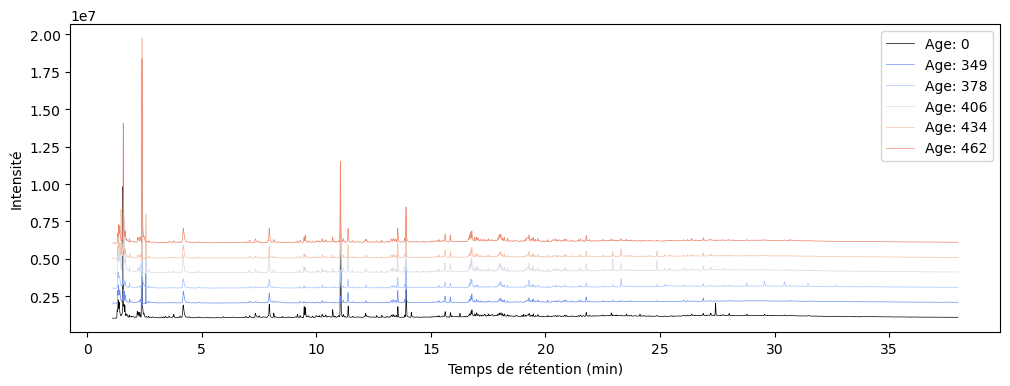

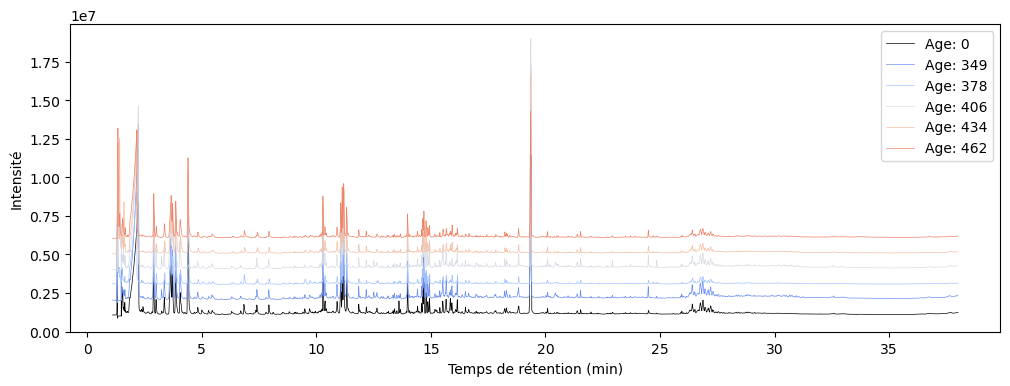

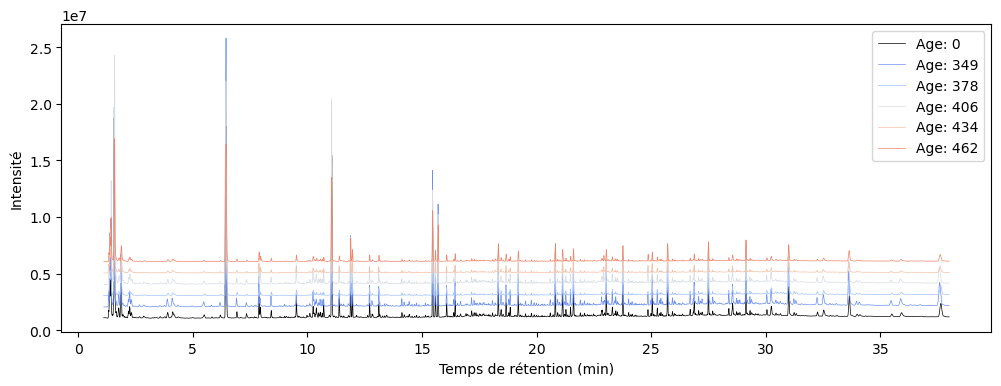

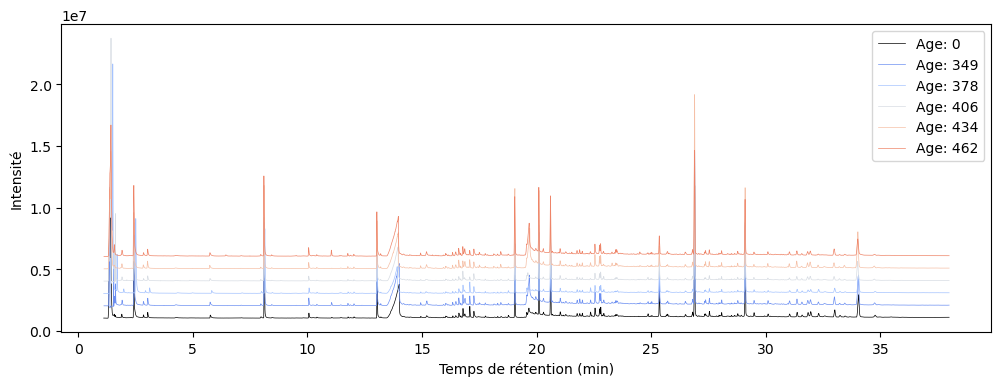

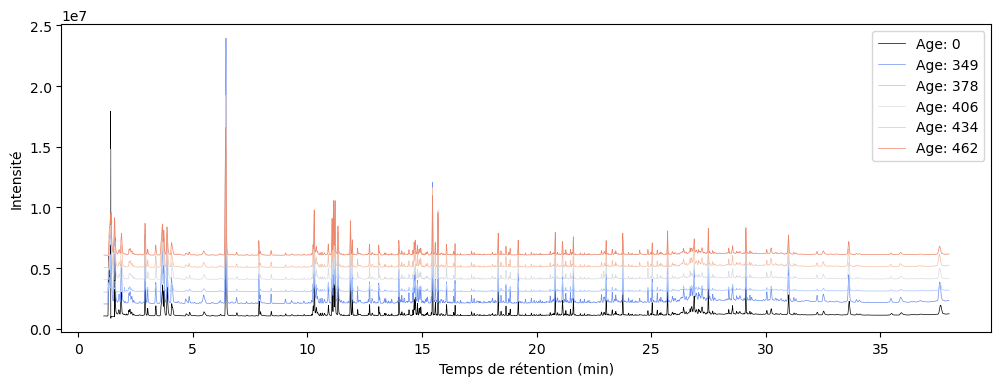

In [27]:
# Figures 21, 24, 27, 30, et Annexes 16, 18, 20, 22, 24
datadata_raa12_vshifted = plot_with_vshift(data_raa12_shifted, 1000000)
datadata_raa13_vshifted = plot_with_vshift(data_raa13_shifted, 1000000)
datadata_raa14_vshifted = plot_with_vshift(data_raa14_shifted, 1000000)
datadata_raa15_vshifted = plot_with_vshift(data_raa15_shifted, 1000000)
datadata_raa16_vshifted = plot_with_vshift(data_raa16_shifted, 1000000)

plot_TIC(datadata_raa12_vshifted, 1.11, 38)
plot_TIC(datadata_raa13_vshifted, 1.11, 38)
plot_TIC(datadata_raa14_vshifted, 1.11, 38)
plot_TIC(datadata_raa15_vshifted, 1.11, 38)
plot_TIC(datadata_raa16_vshifted, 1.11, 38)

raa12


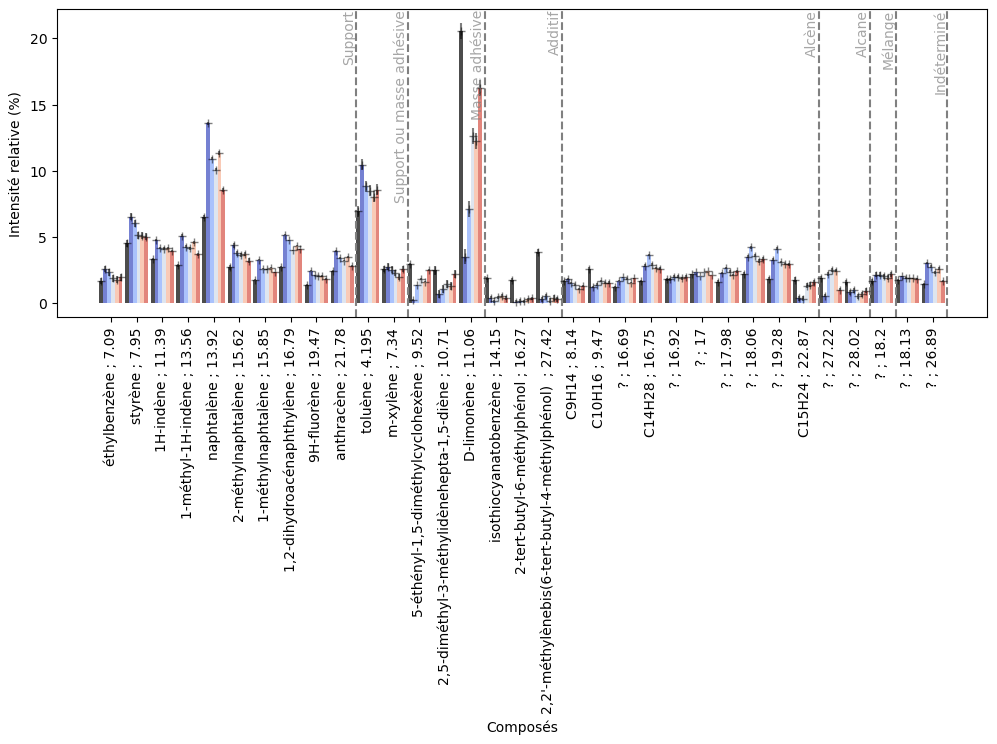

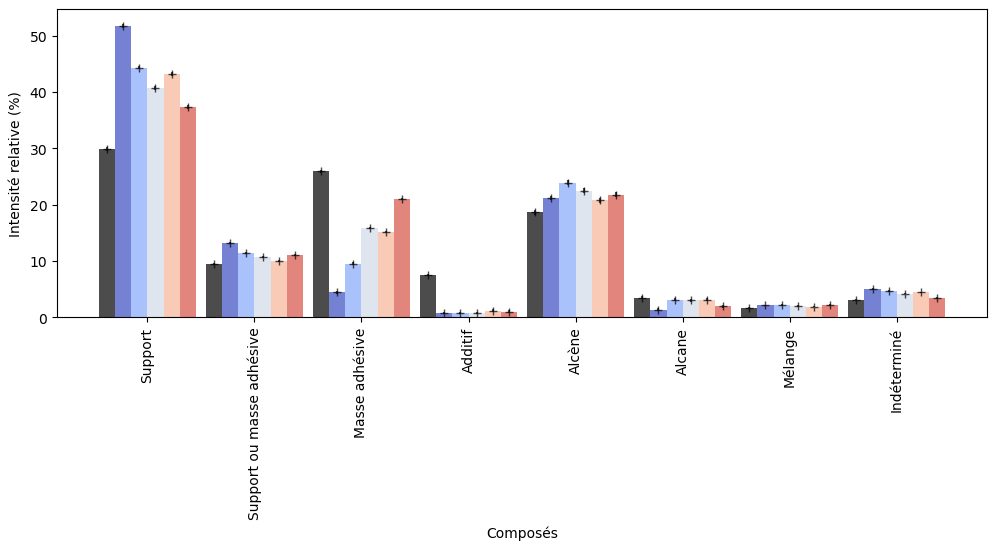

In [28]:
# Figure 22 et Annexe 17
raa_type = 'raa12'

peak_raa_ri_df, retention_times, compounds, compound_types, compound_types_plot, data_raa, retention_to_compound_func, compound_to_compound_type_func, retention_to_compound_type_func, peak_raa_df = initialise_plot_bars_data()
std_devs = std_devs_raa12
std_devs_by_compound_type = std_devs_by_type_raa12
plot_bars_compounds()
plot_bars_compound_types()

raa13


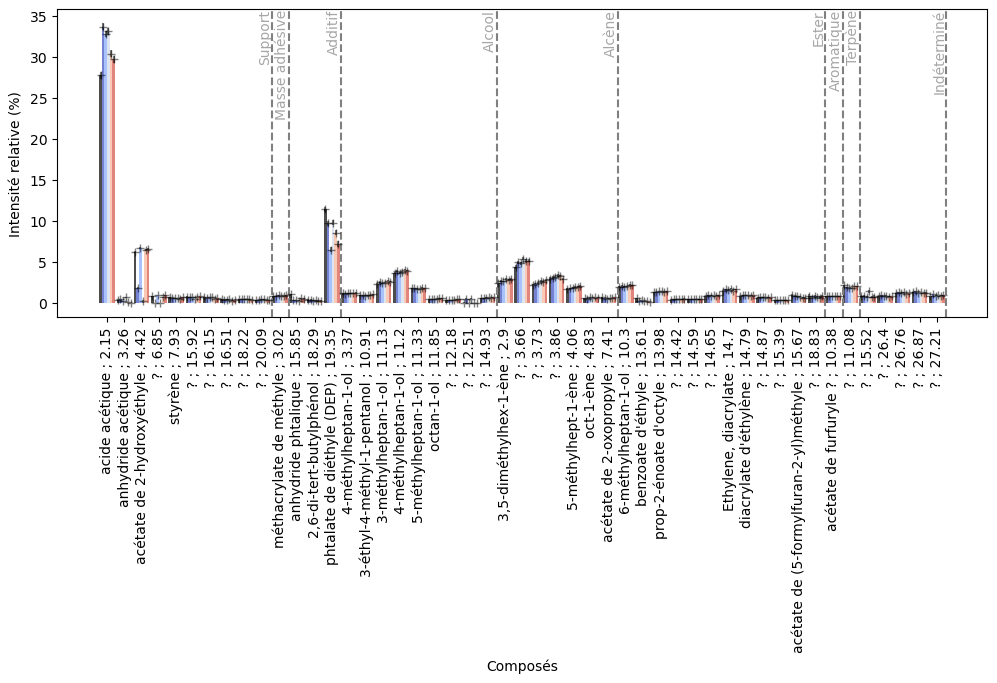

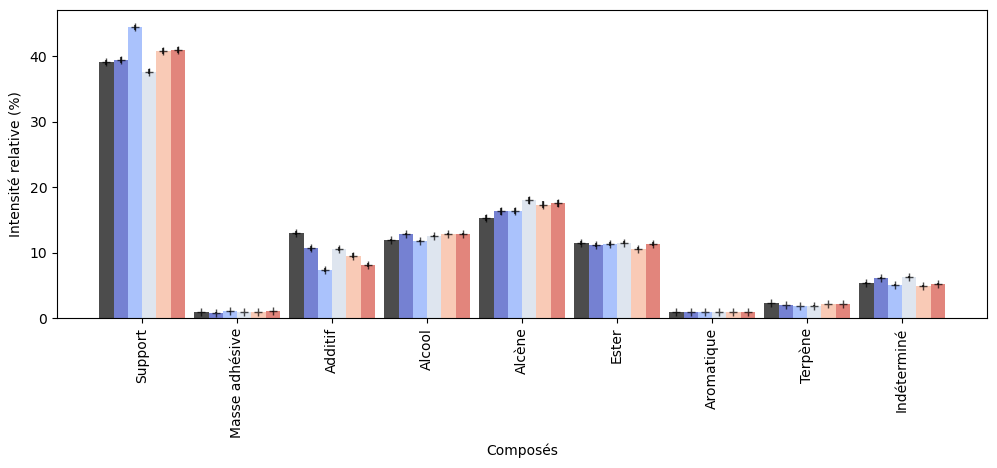

In [29]:
# Annexe 18
raa_type = 'raa13'

peak_raa_ri_df, retention_times, compounds, compound_types, compound_types_plot, data_raa, retention_to_compound_func, compound_to_compound_type_func, retention_to_compound_type_func, peak_raa_df = initialise_plot_bars_data()
std_devs = std_devs_raa13
std_devs_by_compound_type = std_devs_by_type_raa13
plot_bars_compounds()
plot_bars_compound_types()

raa14


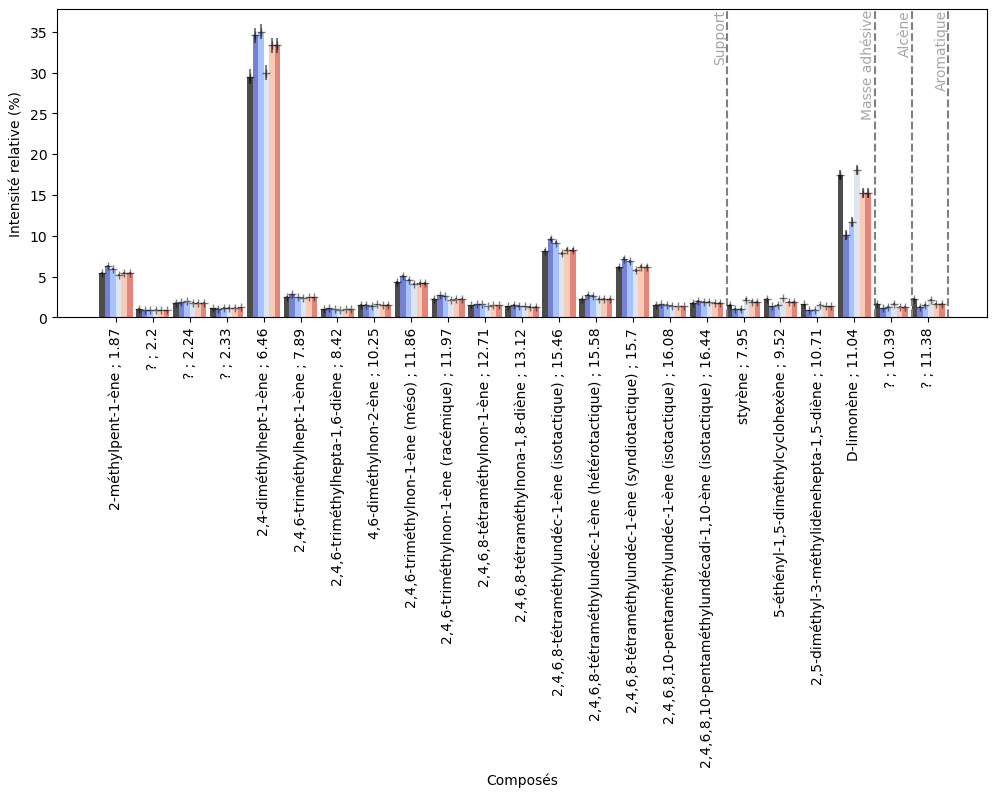

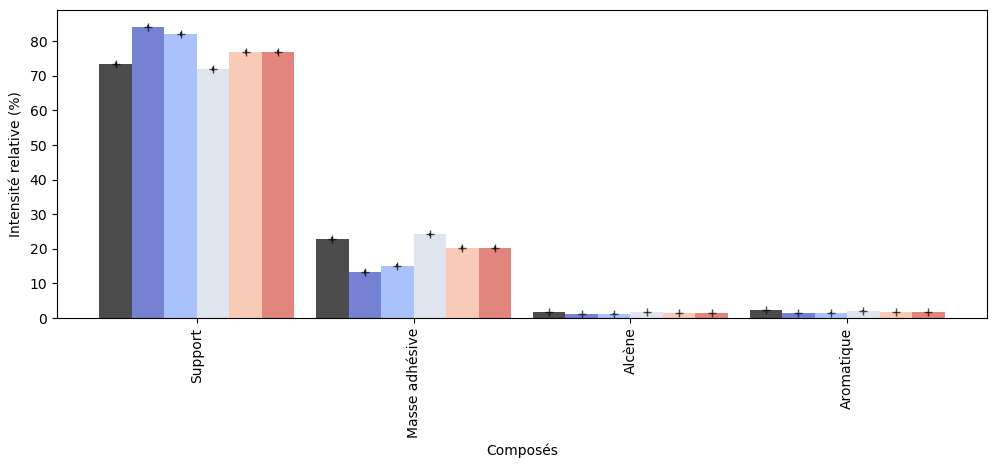

In [30]:
# Annexe 19
raa_type = 'raa14'

peak_raa_ri_df, retention_times, compounds, compound_types, compound_types_plot, data_raa, retention_to_compound_func, compound_to_compound_type_func, retention_to_compound_type_func, peak_raa_df = initialise_plot_bars_data()
std_devs = std_devs_raa14
std_devs_by_compound_type = std_devs_by_type_raa14
plot_bars_compounds()
plot_bars_compound_types()

raa15


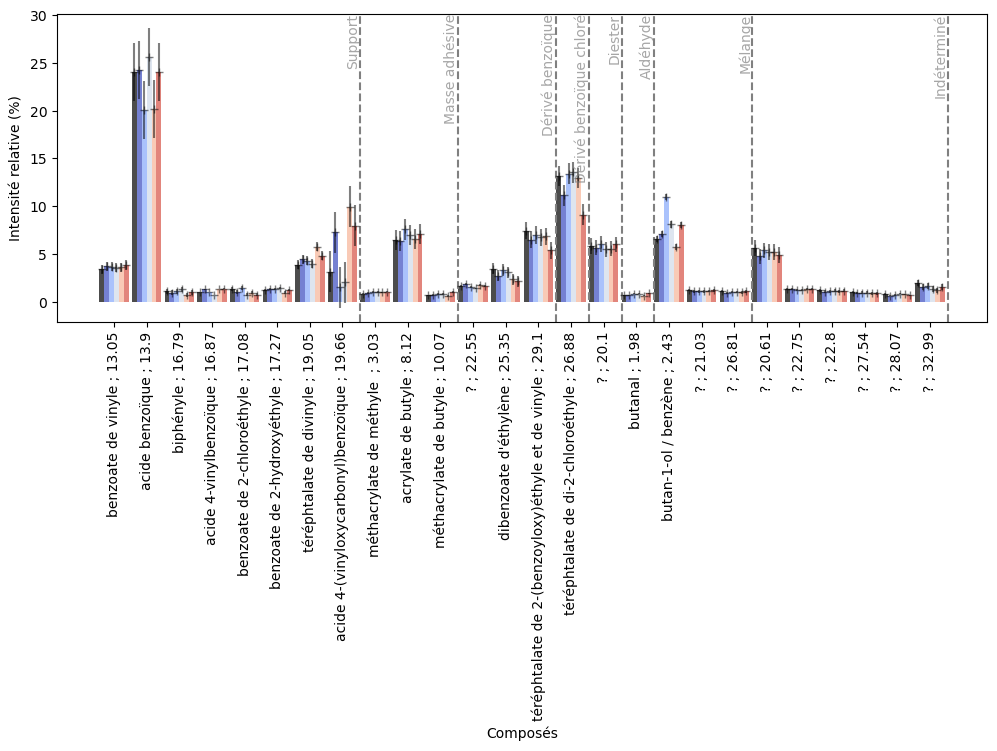

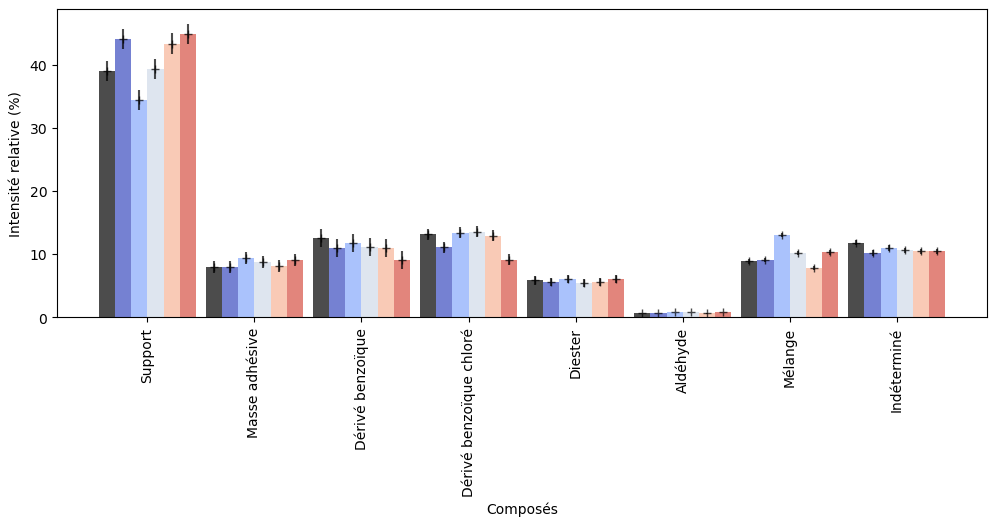

In [31]:
# Annexe 20
raa_type = 'raa15'

peak_raa_ri_df, retention_times, compounds, compound_types, compound_types_plot, data_raa, retention_to_compound_func, compound_to_compound_type_func, retention_to_compound_type_func, peak_raa_df = initialise_plot_bars_data()
std_devs = std_devs_raa15
std_devs_by_compound_type = std_devs_by_type_raa15
plot_bars_compounds()
plot_bars_compound_types()

raa16


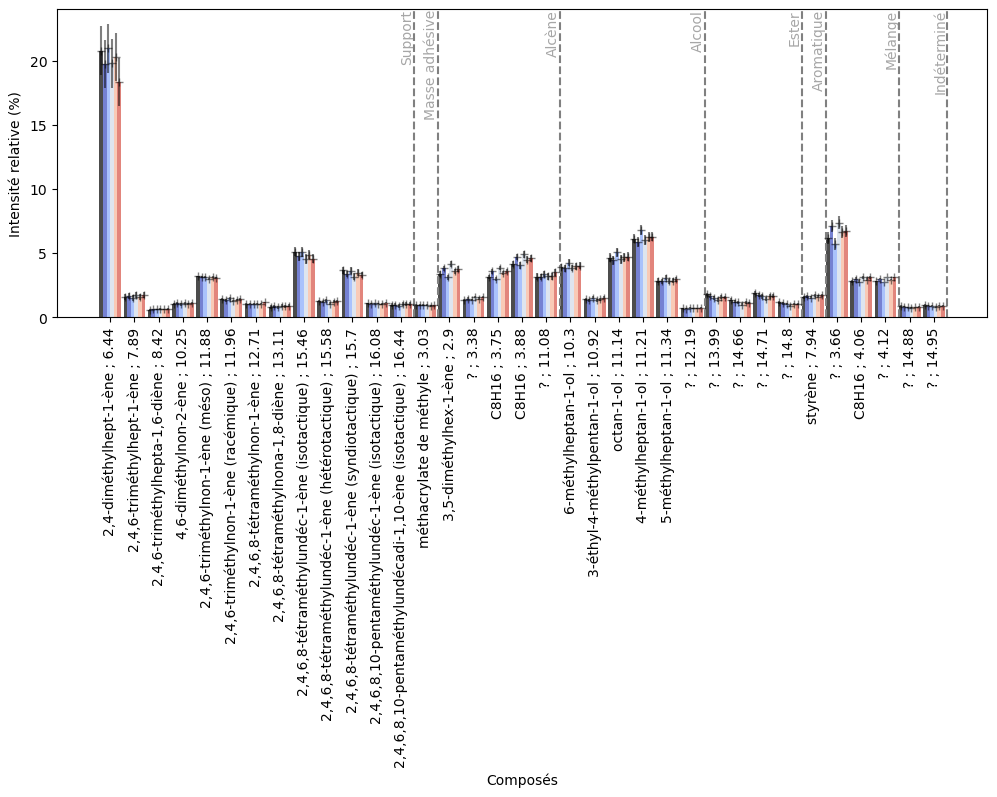

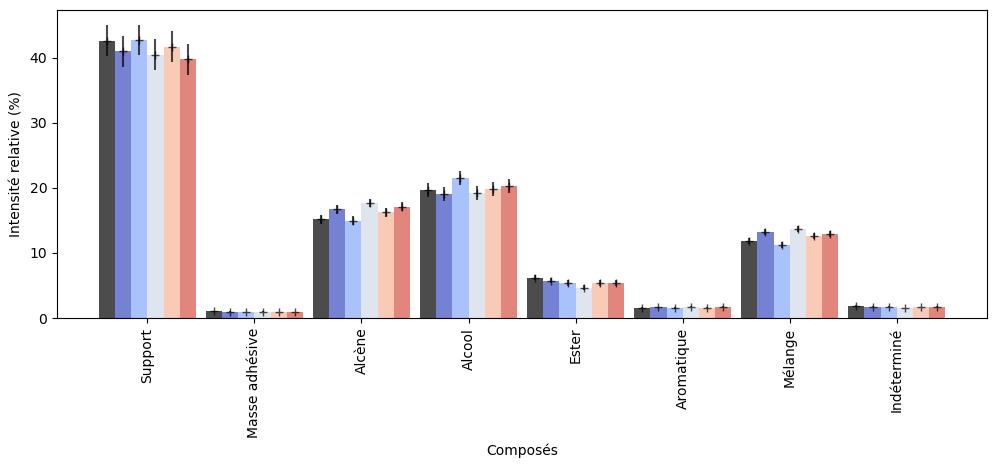

In [32]:
# Annexe 21
raa_type = 'raa16'

peak_raa_ri_df, retention_times, compounds, compound_types, compound_types_plot, data_raa, retention_to_compound_func, compound_to_compound_type_func, retention_to_compound_type_func, peak_raa_df = initialise_plot_bars_data()
std_devs = std_devs_raa16
std_devs_by_compound_type = std_devs_by_type_raa16
plot_bars_compounds()
plot_bars_compound_types()

In [33]:
from sklearn.preprocessing import StandardScaler, Normalizer

def extract_data(data, deriv, normalization='standard'):
    lab = data.values[:, 0]
    feat = data.values[:, 1:-3].astype('float32')
    
    if normalization == 'standard':
        scaler = StandardScaler()
    elif normalization == 'normalise':
        scaler = Normalizer()
    else:
        scaler = None
    
    if scaler:
        nfeat = scaler.fit_transform(feat)
    else:
        nfeat = feat
    
    if deriv == 1:
        dfeat = savgol_filter(feat, 25, polyorder=5, deriv=1)
        if scaler:
            ndfeat = scaler.fit_transform(dfeat)
        else:
            ndfeat = dfeat
        return ndfeat, lab
    elif deriv == 2:
        ddfeat = savgol_filter(feat, 25, polyorder=5, deriv=2)
        if scaler:
            nddfeat = scaler.fit_transform(ddfeat)
        else:
            nddfeat = ddfeat
        return nddfeat, lab
    
    return nfeat, lab

In [34]:
def apply_PCA_4(nfeat, method) :

    if method == 'SVD':
        pca = PCA(n_components=4, svd_solver='full')
        Xt = pca.fit_transform(nfeat)
    else:
        raise ValueError("Invalid method. Please choose either 'SVD' or 'NIPALS'.")

    return Xt, pca

In [35]:
from matplotlib.colors import ListedColormap
import matplotlib.lines as mlines

def plot_PCA_map(Xt, lab, data):
    import seaborn as sns
    
    print(Xt[0])
    
    # Define unique values for each plot
    unique1 = sorted(set(lab))
    
    ages = data.values[:, -3]

    with plt.style.context('ggplot'):
        plt.figure(figsize=(6, 6))
        
        handles = []  # List to store custom legend handles
        
        for u in unique1:
            for i in range(len(Xt[lab == u, 0])):
                xi = Xt[lab == u, 0]  # Filter x values by species
                yi = Xt[lab == u, 1]  # Filter y values by species

                filtered_ages = ages[lab == u]
                non_zero_ages = filtered_ages[filtered_ages > 0]

                if len(non_zero_ages) > 1:
                    second_min_age = np.sort(non_zero_ages)[0]  # Smallest non-zero age
                    ages_variation = (filtered_ages - second_min_age) / (filtered_ages.max() - second_min_age)
                else:
                    ages_variation = np.zeros_like(filtered_ages)

                color_map_idx = np.round(ages_variation[i] * 255).astype(int)

                if u == 'raa12':
                    adjusted_color = plt.cm.PiYG(np.linspace(0.1, 0.4, 256))
                if u == 'raa13':
                    adjusted_color = plt.cm.PiYG(np.linspace(0.9, 0.6, 256))
                if u == 'raa14':
                    adjusted_color = plt.cm.RdGy(np.linspace(0.9, 0.6, 256))
                if u == 'raa15':
                    adjusted_color = plt.cm.BrBG(np.linspace(0.9, 0.6, 256))
                if u == 'raa16':
                    adjusted_color = plt.cm.PuOr(np.linspace(0.1, 0.4, 256))

                # Plot only one label for each unique type
                edge_width = 0.2
                if filtered_ages[i] == 0:
                    color = adjusted_color[np.round((second_min_age - second_min_age) / (filtered_ages.max() - second_min_age) * 255).astype(int)]
                    edge_width = 1
                else:
                    color = adjusted_color[color_map_idx]

                if i == 0:
                    plt.scatter(xi[i], yi[i], color=color, s=75, edgecolors='k', linewidths=edge_width, label=str(u), alpha=0.7)
                    handles.append(mlines.Line2D([], [], color=adjusted_color[75], alpha=0.7, marker='o', linestyle='None', label=str(u)))
                else:
                    plt.scatter(xi[i], yi[i], color=color, s=75, edgecolors='k', linewidths=edge_width, alpha=0.7)

        plt.xlabel('PC1', fontsize='x-large')
        plt.ylabel('PC2', fontsize='x-large')
        plt.legend(loc='upper right', handles=handles, fontsize=12, markerscale=1.2)
        #plt.set_title('Principal Component Analysis (tape type)', fontsize='xx-large')
        
        plt.tight_layout()  # Adjust layout to prevent overlap
        plt.savefig(r'C:\Users\n.gros\Desktop\PCA.png')
        plt.show()

In [36]:
def fPCA(data, deriv, method, normalisation):
    print('Clair = vieux')
    nfeat, lab = extract_data(data, deriv, normalisation)
    Xt, pca = apply_PCA_4(nfeat, method)
    plot_PCA_map(Xt, lab, data)
    return pca.components_

In [37]:
fPCA(data, 0, 'SVD', 'normalise')

Clair = vieux


NameError: name 'PCA' is not defined

In [ ]:
fPCA(data_raa12, 0, 'SVD', 'normalise')
fPCA(data_raa13, 0, 'SVD', 'normalise')
fPCA(data_raa14, 0, 'SVD', 'normalise')
fPCA(data_raa15, 0, 'SVD', 'normalise')
fPCA(data_raa16, 0, 'SVD', 'normalise')

In [ ]:
def display_loadings(pca_components, features):
    n_components = pca_components.shape[0]
    n_components = 2
    retention_time = data.columns[1:-3]
    plt.figure(figsize=(12, 6+n_components))
    colors1 = plt.cm.Set1(np.linspace(0, 0.5, n_components))

    for i in range(n_components):
        offset = i/10
        plt.plot(retention_time, pca_components[i] - offset, color=colors1[i], linestyle='-', linewidth=0.5, alpha=1, label=f'PC{i+1}')
        plt.axhline(y=-offset, color='black', linestyle='--', linewidth=0.5)


    plt.xlabel('retention_time')
    plt.ylabel('loading intensity')
    #plt.title('loadings')
    plt.legend()  # Adding legend
    plt.savefig(r'C:\Users\n.gros\Desktop\loadings.png')
    plt.show()

In [ ]:
display_loadings(fPCA(data_raa13, 0, 'SVD', 'normalise'), data_raa13.columns[1:-3])